# ML notebook to predict what stops will be dropped from a route. 

In [83]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from tqdm import tqdm
import numpy as np
from sklearn.cluster import DBSCAN
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score

#NEW modules: please reinstall conda env!!
#we're gonna learn the living baby jesus out of this :)
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

try:
    import tensorflow as tf
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
except:
    print('installing TF')
    #issue with Conda; this works
    ! pip install tensorflow
from sklearn.metrics import accuracy_score

sys.path.append('../utils')
import helpers as h
import feature_engineering as f

In [84]:
ITM_DIR = os.path.join(os.getcwd(), '../data/intermediate')

In [85]:
request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))

C:\Users\tinne\AppData\Local\Temp\ipykernel_78444\291413550.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  request_df = pd.read_csv(os.path.join(ITM_DIR, 'clean_data.csv'))


In [86]:
# add route stop distances as feature
request_df = f.calculate_distances(request_df, 'stop_order')


100%|██████████| 18010/18010 [00:14<00:00, 1263.65it/s]


In [5]:
request_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,RouteId,TriggerType,ConfigurationName,NumberOfTasks,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop
610693,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71108,0.493993,0.315449,2022-06-09T07:30:00,2022-06-09T23:59:00,27,1,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,2.0,False,0.000000,0.000000,0.000949
610694,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71080,0.494289,0.314548,2022-06-09T07:30:00,2022-06-09T17:00:00,14,2,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,2.0,False,0.000949,0.000949,0.003482
610695,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71048,0.493936,0.311083,2022-06-09T07:30:00,2022-06-09T17:00:00,176,3,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,2.0,False,0.003482,0.004431,0.005125
610696,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71177,0.491165,0.315395,2022-06-09T00:00:00,2022-06-09T23:59:00,134,4,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,2.0,False,0.005125,0.009556,0.001414
610697,0000eb3f-b669-476c-bec3-858b8286e193,CreateSequence,71049,0.490411,0.316590,2022-06-09T07:30:00,2022-06-09T23:59:00,177,5,0521_612-20220609,...,0521_612,FullOptimization,CreateSequence,204.0,0.0,2.0,False,0.001414,0.010970,0.001499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766866,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65498,0.578363,0.098513,2022-06-17T07:30:00,2022-06-17T23:59:00,100,100,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,5.0,True,0.000000,0.180777,0.000000
1766867,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65493,0.578363,0.098513,2022-06-17T07:30:00,2022-06-17T23:59:00,101,101,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,5.0,True,0.000000,0.180777,0.000441
1766868,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65408,0.578175,0.098912,2022-06-17T07:30:00,2022-06-17T23:59:00,102,102,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,5.0,True,0.000441,0.181218,0.000113
1766869,ffff6e26-f5a6-423e-b4dc-40bfd82cce12,AddToSequence,65388,0.578287,0.098896,2022-06-17T07:30:00,2022-06-17T23:59:00,103,103,0521_890-20220617,...,0521_890,AdditionalOrders,AddToSequence,104.0,102.0,5.0,True,0.000113,0.181331,0.000000


In [87]:
## add route centers as feature. 
request_df = f.get_route_center(request_df)


In [88]:
# add gets_dropped as feature. 
initial_dfs = []
for _, df in request_df.groupby('dir'):
    #Time is the timestamp coming from serverlog: compare first request wiht last non-PM request
    # REMEMBER THAT: PM requests where filtered out already.
    first_request_timestamp = df['Time'].min()
    last_request_timestamp = df['Time'].max()
    #get the first and last request as dfs: 
    first_request_df = df.loc[df['Time'] == first_request_timestamp]
    last_request_df = df.loc[df['Time'] == last_request_timestamp]
    #Only interested in dropped for generating MLs on dropping stops. 
    #TODO ==> Someone: run statistics on common, added, dropped. 
    common, added, dropped = f.stop_diffs(first_request_df, last_request_df)
    #add the column "gets_dropped" to first_request_df and set it to 1 if first_request_df.id is in dropped else 0
    first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
    initial_dfs.append(first_request_df)

C:\Users\tinne\AppData\Local\Temp\ipykernel_78444\2469773114.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
C:\Users\tinne\AppData\Local\Temp\ipykernel_78444\2469773114.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_request_df['gets_dropped'] = first_request_df['id'].apply(lambda x: 1 if x in dropped else 0)
C:\Users\tinne\AppData\Local\Temp\ipykernel_78444\2469773114.py:15: SettingWithCopyW

In [89]:
initial_routes_df = pd.concat(initial_dfs)
initial_routes_df

,file_uuid,configurationName,id,lat,long,start_time,end_time,server_task_number,stop_order,dir,...,NumberOfTasksInInputPlan,request_day_route_order,request_day_route_is_last,dist_since_prev,dist_cumulative,dist_to_next_stop,mean_lat,mean_long,dst_point_to_center,gets_dropped
0,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,394,0.565826,0.221868,2022-06-17T07:30:00,2022-06-17T18:00:00,2,1,0521_300-20220617,...,0.0,3.0,False,0.000000,0.000000,0.000000,0.566974,0.223775,0.002225,1
1,41931cd2-8975-4a64-9197-d16abe871bb7,CreateSequence,395,0.565826,0.221868,2022-06-17T08:00:00,2022-06-17T17:00:00,1,2,0521_300-20220617,...,0.0,3.0,False,0.000000,0.000000,NaN,0.566974,0.223775,0.002225,1
6,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64869,0.650488,0.296025,2022-05-30T00:00:00,2022-05-30T12:00:00,1,1,0521_301-20220530,...,154.0,1.0,False,0.000000,0.000000,0.004470,0.645124,0.305079,0.010524,0
7,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64947,0.646361,0.297741,2022-05-30T00:00:00,2022-05-30T12:00:00,2,2,0521_301-20220530,...,154.0,1.0,False,0.004470,0.004470,0.000907,0.645124,0.305079,0.007442,0
8,cb9638db-2817-4ccf-b226-7775c01793a8,EstimateTime,64971,0.645787,0.298443,2022-05-30T00:00:00,2022-05-30T12:00:00,3,3,0521_301-20220530,...,154.0,1.0,False,0.000907,0.005377,0.000000,0.645124,0.305079,0.006669,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120370,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63656,0.484775,0.297222,2022-06-22T07:30:00,2022-06-22T23:59:00,95,131,0521_O69-20220622,...,0.0,5.0,False,0.000488,0.124391,0.001346,0.482994,0.303785,0.006801,0
2120371,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63654,0.486119,0.297154,2022-06-22T07:30:00,2022-06-22T23:59:00,97,132,0521_O69-20220622,...,0.0,5.0,False,0.001346,0.125737,0.000954,0.482994,0.303785,0.007331,0
2120372,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63653,0.485895,0.296226,2022-06-22T07:30:00,2022-06-22T23:59:00,98,133,0521_O69-20220622,...,0.0,5.0,False,0.000954,0.126691,0.000513,0.482994,0.303785,0.008097,0
2120373,642acef2-3942-4057-aeb8-61df9f7ffa1b,CreateSequence,63652,0.485559,0.295839,2022-06-22T07:30:00,2022-06-22T23:59:00,99,134,0521_O69-20220622,...,0.0,5.0,False,0.000513,0.127204,0.000000,0.482994,0.303785,0.008351,0


## ML Phase: 

In [9]:
models = {}

Feature engineering done; let's see what we're dealing with.

In [90]:
initial_routes_df.gets_dropped.mean()
#14.5% of initial route stops get dropped

0.1455619853493942

In [91]:
# Only keep needed columns into ml_df 
ml_df = initial_routes_df[['lat', 'long', 'stop_order', 'dist_since_prev', 
                          'dist_cumulative', 'dist_to_next_stop', 'mean_lat',
                          'mean_long', 'dst_point_to_center', 'gets_dropped']]

In [92]:
#scaling not really needed here it's all done already. 
ml_df

,lat,long,stop_order,dist_since_prev,dist_cumulative,dist_to_next_stop,mean_lat,mean_long,dst_point_to_center,gets_dropped
0,0.565826,0.221868,1,0.000000,0.000000,0.000000,0.566974,0.223775,0.002225,1
1,0.565826,0.221868,2,0.000000,0.000000,NaN,0.566974,0.223775,0.002225,1
6,0.650488,0.296025,1,0.000000,0.000000,0.004470,0.645124,0.305079,0.010524,0
7,0.646361,0.297741,2,0.004470,0.004470,0.000907,0.645124,0.305079,0.007442,0
8,0.645787,0.298443,3,0.000907,0.005377,0.000000,0.645124,0.305079,0.006669,0
...,...,...,...,...,...,...,...,...,...,...
2120370,0.484775,0.297222,131,0.000488,0.124391,0.001346,0.482994,0.303785,0.006801,0
2120371,0.486119,0.297154,132,0.001346,0.125737,0.000954,0.482994,0.303785,0.007331,0
2120372,0.485895,0.296226,133,0.000954,0.126691,0.000513,0.482994,0.303785,0.008097,0
2120373,0.485559,0.295839,134,0.000513,0.127204,0.000000,0.482994,0.303785,0.008351,0


In [93]:
#shuffle df: 
ml_df = ml_df.sample(frac=1).reset_index(drop=True)

In [94]:
#Train test split with a validation set! (strafied based on target (gets_dropped))
y_name = 'gets_dropped'
train_ratio = 70
test_ratio = 20
validation_ratio = 10
stratcols = [y_name]    #stratify on target only
train_df, test_df, validation_df = h.train_test_val_splitter(
                                ml_df, 
                                train_ratio,
                                test_ratio,
                                validation_ratio, 
                                stratcols
                            )

X_train, y_train = h.get_X_y(train_df, y_name)
X_test, y_test = h.get_X_y(test_df, y_name)
#DON'T TOUCH X_val and y_val now!!!!
X_val, y_val = h.get_X_y(validation_df, y_name)
#TODO use validation set in final model comparison. 

### XGBOOST classifier: 

In [15]:
### XGBOOST BINARY CLASSIFIER: 1 or 0 (drop out(1) or not(0))
xgb_model_binclass = xgb.XGBClassifier(
    objective="binary:logistic", 
    eval_metric="logloss", 
    use_label_encoder=False
)

xgb_model_binclass.fit(X_train, y_train)
y_pred = xgb_model_binclass.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

models['xgboost'] = xgb_model_binclass

c:\Users\tinne\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:36:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9148455256125277


## Classification metrics

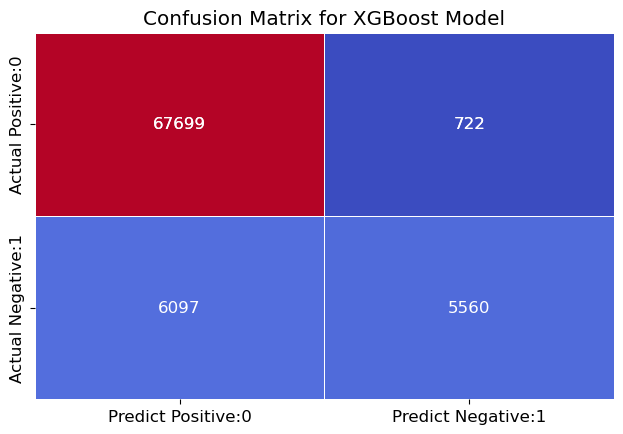

In [ ]:
cm = confusion_matrix(y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm, index=['Actual Positive:0', 'Actual Negative:1'], 
                                 columns=['Predict Positive:0', 'Predict Negative:1'])


sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm',
            cbar=False, linewidths=0.5)

# Manually add text annotations as seaborn was not showing bottom text
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        plt.text(j + 0.5, i + 0.5, str(value),
                 ha='center', va='center',
                 fontsize=12, color='white')
        
plt.title("Confusion Matrix for XGBoost Model")
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

In [55]:
cm_matrix

,Actual Positive:1,Actual Negative:0
Predict Positive:1,67699,722
Predict Negative:0,6097,5560


## ROC curve

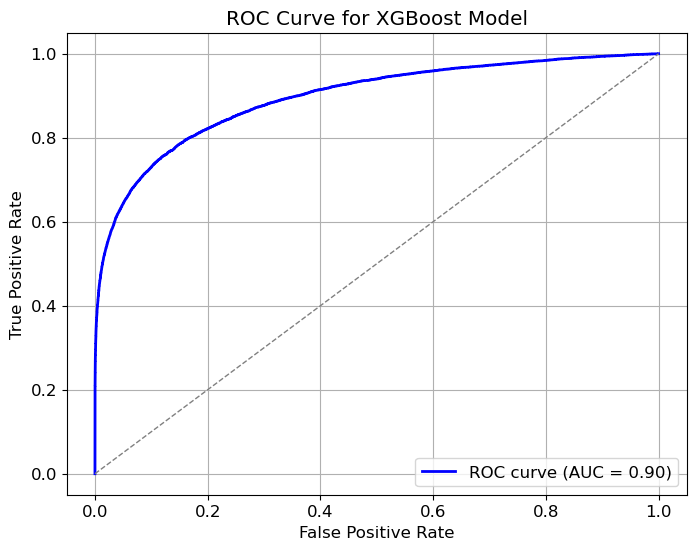

In [ ]:
# Get predicted probabilities for the positive class
y_prob = xgb_model_binclass.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Random Forest classifier: 

In [100]:
X_test.isna().sum()

lat                      0
long                     0
stop_order               0
dist_since_prev          0
dist_cumulative          0
dist_to_next_stop      693
mean_lat                 0
mean_long                0
dst_point_to_center      0
dtype: int64

In [101]:
# replace missing values with 0
X_test.fillna(0, inplace=True)

In [102]:
e = 15 #Play around with this as needed
random_forest_binclassifier = RandomForestClassifier(n_estimators = e)
random_forest_binclassifier.fit(X_train, y_train)
y_pred = random_forest_binclassifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
models['random_forest_classifier'] = random_forest_binclassifier
print(accuracy)

0.9288693523814281


rfc is slightly better on unseen data than XGBOOST - 15 seems about to be a sweetspot; optimimum can be bruteforced if someone has the time. 

In [59]:
X_train.sample(5)

c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\IPython\core\formatters.py:406: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,lat,long,stop_order,dist_since_prev,dist_cumulative,dist_to_next_stop,mean_lat,mean_long,dst_point_to_center
387133,0.570692,0.176764,61,0.000382,0.056867,0.004199,0.570798,0.175657,0.001112
185176,0.479957,0.175684,166,0.000955,0.207383,0.000787,0.483745,0.152584,0.023409
220035,0.543590,0.213914,5,0.005456,0.017423,0.003223,0.545231,0.215856,0.002542
50304,0.666139,0.234096,141,0.001763,0.129694,0.001360,0.662056,0.236386,0.004682
23299,0.563526,0.133039,73,0.000000,0.096576,0.000395,0.556727,0.136915,0.007826


## Classification metrics

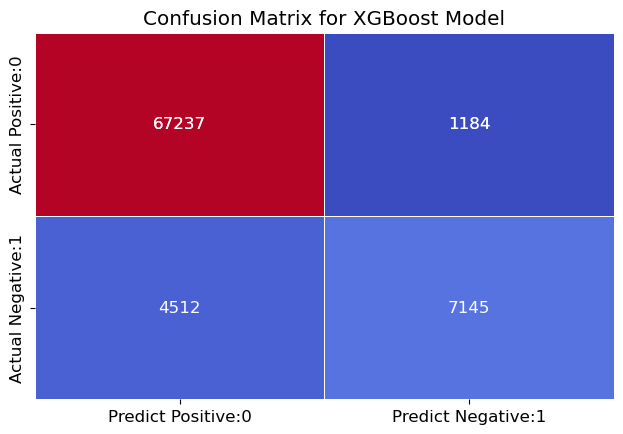

In [103]:
cm = confusion_matrix(y_test, y_pred)

cm_matrix = pd.DataFrame(data=cm, index=['Actual Positive:0', 'Actual Negative:1'], 
                                 columns=['Predict Positive:0', 'Predict Negative:1'])


sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm',
            cbar=False, linewidths=0.5)

# Manually add text annotations as seaborn was not showing bottom text
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        plt.text(j + 0.5, i + 0.5, str(value),
                 ha='center', va='center',
                 fontsize=12, color='white')
        
plt.title("Confusion Matrix for XGBoost Model")
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## ROC curve

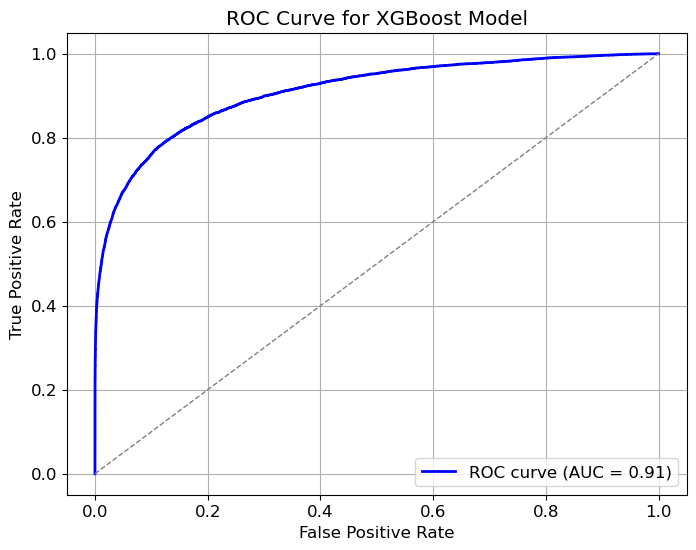

In [104]:
# Get predicted probabilities for the positive class
y_prob = xgb_model_binclass.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Deep learning:
With callbacks for early stopping and lroptimization and class weights (still an AI with dementia due to heavy class imbalance)

In [77]:
#CW needed because dataset is heavily imbalanced: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

dl_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(len(X_train.columns),)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
dl_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

dl_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    class_weight=class_weights, 
    callbacks=[early_stopping, reduce_lr]
)

models['deeplearn'] = dl_model


c:\Users\Frede\.conda\envs\env_learning_driver_preferences\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
17518/17518 ━━━━━━━━━━━━━━━━━━━━ 90s 5ms/step - accuracy: 0.3997 - loss: 0.7189 - val_accuracy: 0.8544 - val_loss: 0.6915 - learning_rate: 0.0010
Epoch 2/50
17518/17518 ━━━━━━━━━━━━━━━━━━━━ 98s 2ms/step - accuracy: 0.6198 - loss: 0.6924 - val_accuracy: 0.8544 - val_loss: 0.6878 - learning_rate: 0.0010
Epoch 3/50
17518/17518 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.6840 - loss: 0.6914 - val_accuracy: 0.1456 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 4/50
17518/17518 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.5866 - loss: 0.6914 - val_accuracy: 0.8544 - val_loss: 0.6884 - learning_rate: 0.0010
Epoch 5/50
17518/17518 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5492 - loss: 0.6931
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17518/17518 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.5492 - loss: 0.6931 - val_accuracy: 0.1456 - val_loss: 0.7006 - learning_rate: 0.0010
Epoch 6/50
17518/17518 ━━━━━━━━━━━━━━━━━━━━ 103s 4ms/step - 

In [79]:
dl_model.predict(X_val)#worthless

1252/1252 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step


array([[0.496202],
       [0.496202],
       [0.496202],
       ...,
       [0.496202],
       [0.496202],
       [0.496202]], dtype=float32)